In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)


import tensorflow.keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py
from keras import callbacks 
import keras
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

In [2]:
#retrieve data
num = 2000 # number of profiles
nvza = 2 # number of channels
nsza=1



In [3]:
os = 1 # output slice size
halo=2
ts = 1+halo*2 # input slice size 
l2r=78
num=2000

In [4]:
#get the averaged reflectance from the dataset 
r=np.load('monte_carlo_r.npy')
r.shape

(2000, 82, 1, 2)

In [5]:
r=r.reshape((2000, 82, 2))

In [6]:
#get the averaged reflectance from the dataset 
c=np.load('monte_carlo_cot.npy')
c.shape

(2000, 82)

In [7]:
r,c= shuffle(r, c, random_state=1)#Shuffle arrays in a consistent way.

#train test split
trp = 0.8; # 80 percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #20% for testing:0.20*4000=800

print("train_size:",train_size,'profiles')
print("test_size:",test_size,'profiles')

train_size: 1600 profiles
test_size: 400 profiles


In [8]:
r.shape

(2000, 82, 2)

In [9]:
#spatial slicing the 4000 profiles 

image=np.zeros((l2r*num,5,2)) 
label=np.zeros((l2r*num,1)) 


for i in range(num):
    for n in range(l2r):
            img= r[i,n*os:n*os+ts,:2] 
            lb = c[i,n*os+halo:n*os+halo+os] 
            image[i*l2r+n]=img
            label[i*l2r+n]=lb 
print('whole dataset features size: ',image.shape,'whole dataset label size: ', label.shape) #4066*4000=16264000


whole dataset features size:  (156000, 5, 2) whole dataset label size:  (156000, 1)


In [10]:
keras.utils.plot_model(model_m, show_shapes=True,show_layer_names=True,expand_nested=True,rankdir='TB')


NameError: name 'model_m' is not defined

In [11]:
# CNN over domain -------------------------------------------

ltype = 'mean_squared_error'
type2=tf.keras.metrics.RootMeanSquaredError()
bsize = 32
eps = 4000

def eval_model(train_image, test_image, train_label, test_label):


    input_layer=tf.keras.layers.Input(shape=(ts,2),name='Input')
    conv1=tf.keras.layers.Conv1D(300, kernel_size=3, activation='relu', input_shape=(ts,2))(input_layer) #kernel size 6, 100 filters for each 3 channel
    conv2=tf.keras.layers.Conv1D(240, kernel_size=3, activation='relu')(conv1) #kernel size 4, 80 filters for each 3 channel
   # model_m.add(layers.Dropout(0.2))
    conv3=tf.keras.layers.Conv1D(80, kernel_size=1)(conv2)
    #model_m.add(layers.Dropout(0.2))
    flat=tf.keras.layers.Flatten()(conv3)
    out=tf.keras.layers.Dense(os, activation="linear")(flat)#output slice size : 1
    model = tf.keras.models.Model(inputs=input_layer, outputs=out)


   

    model.compile(optimizer='adam',loss='mse',metrics=[ltype,type2])
    model.summary()


    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 25,  
                                                restore_best_weights = True,
                                               verbose=1) 

    history = model.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.25,
                              callbacks =[earlystopping])

    # test and predict ------------------------------------------------------------------------------------

    print('test result')
    results = model.evaluate(test_image, test_label)
    predictions=model.predict(test_image)

    mse = results[1]
    rmse = results[2]
    
    return model,rmse,mse,history,predictions,results

In [12]:
n_folds=5

kf = KFold(n_splits=n_folds,random_state=None, shuffle=False)
print(kf.get_n_splits(r))
print(kf)
ratio=int(r.shape[0]/n_folds)

X_train=np.zeros((5,78*400*4,ts,2)) #train: 800*4  test:800
y_train=np.zeros((5,78*400*4,os))
X_test=np.zeros((n_folds,78*ratio,ts,2))
y_test=np.zeros((n_folds,78*ratio,os))

count=0
for train_index, test_index in kf.split(image):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = image[train_index], image[test_index] #r: radiance dataset
    y_train[count], y_test[count] = label[train_index], label[test_index] #c: cot dataset(label)
    count+=1

5
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 31200  31201  31202 ... 155997 155998 155999] TEST: [    0     1     2 ... 31197 31198 31199]
TRAIN: [     0      1      2 ... 155997 155998 155999] TEST: [31200 31201 31202 ... 62397 62398 62399]
TRAIN: [     0      1      2 ... 155997 155998 155999] TEST: [62400 62401 62402 ... 93597 93598 93599]
TRAIN: [     0      1      2 ... 155997 155998 155999] TEST: [ 93600  93601  93602 ... 124797 124798 124799]
TRAIN: [     0      1      2 ... 124797 124798 124799] TEST: [124800 124801 124802 ... 155997 155998 155999]


In [13]:
# evaluate model----------------------------------------------------------------------------------------------
cv_scores = list()
cv_scores2 = list()

for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
        # evaluate model
    model,rmse,mse,history,predictions,results= eval_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 5, 2)]            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 3, 300)            2100      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 240)            216240    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 80)             19280     
_________________________________________________________________
flatten (Flatten)            (None, 80)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 81        
Total params: 237,701
Trainable params: 237,701
Non-trainable params: 0
_______________________________________________________

Epoch 30/4000
2925/2925 [==============================] - 15s 5ms/step - loss: 9.1652 - mean_squared_error: 9.1652 - root_mean_squared_error: 3.0264 - val_loss: 10.6696 - val_mean_squared_error: 10.6696 - val_root_mean_squared_error: 3.2664
Epoch 31/4000
2925/2925 [==============================] - 15s 5ms/step - loss: 9.3828 - mean_squared_error: 9.3828 - root_mean_squared_error: 3.0629 - val_loss: 9.8973 - val_mean_squared_error: 9.8973 - val_root_mean_squared_error: 3.1460
Epoch 32/4000
2925/2925 [==============================] - 15s 5ms/step - loss: 9.1556 - mean_squared_error: 9.1556 - root_mean_squared_error: 3.0256 - val_loss: 10.1336 - val_mean_squared_error: 10.1336 - val_root_mean_squared_error: 3.1833
Epoch 33/4000
2925/2925 [==============================] - 15s 5ms/step - loss: 9.1991 - mean_squared_error: 9.1991 - root_mean_squared_error: 3.0326 - val_loss: 9.5716 - val_mean_squared_error: 9.5716 - val_root_mean_squared_error: 3.0938
Epoch 34/4000
2925/2925 [===========

2925/2925 [==============================] - 15s 5ms/step - loss: 6.9985 - mean_squared_error: 6.9985 - root_mean_squared_error: 2.6453 - val_loss: 8.4287 - val_mean_squared_error: 8.4287 - val_root_mean_squared_error: 2.9032
Epoch 99/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 6.9934 - mean_squared_error: 6.9934 - root_mean_squared_error: 2.6442 - val_loss: 8.5390 - val_mean_squared_error: 8.5390 - val_root_mean_squared_error: 2.9222
Epoch 100/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 6.8898 - mean_squared_error: 6.8898 - root_mean_squared_error: 2.6246 - val_loss: 8.7024 - val_mean_squared_error: 8.7024 - val_root_mean_squared_error: 2.9500
Epoch 101/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 6.9917 - mean_squared_error: 6.9917 - root_mean_squared_error: 2.6441 - val_loss: 8.6221 - val_mean_squared_error: 8.6221 - val_root_mean_squared_error: 2.9363
Epoch 102/4000
2925/2925 [==========================

2925/2925 [==============================] - 14s 5ms/step - loss: 6.5112 - mean_squared_error: 6.5112 - root_mean_squared_error: 2.5515 - val_loss: 8.1127 - val_mean_squared_error: 8.1127 - val_root_mean_squared_error: 2.8483
Epoch 133/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 6.3291 - mean_squared_error: 6.3291 - root_mean_squared_error: 2.5153 - val_loss: 8.2088 - val_mean_squared_error: 8.2088 - val_root_mean_squared_error: 2.8651
Epoch 134/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 6.3730 - mean_squared_error: 6.3730 - root_mean_squared_error: 2.5243 - val_loss: 8.2573 - val_mean_squared_error: 8.2573 - val_root_mean_squared_error: 2.8735
Epoch 135/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 6.3399 - mean_squared_error: 6.3399 - root_mean_squared_error: 2.5176 - val_loss: 8.0915 - val_mean_squared_error: 8.0915 - val_root_mean_squared_error: 2.8445
Epoch 136/4000
2925/2925 [=========================

2925/2925 [==============================] - 15s 5ms/step - loss: 6.1226 - mean_squared_error: 6.1226 - root_mean_squared_error: 2.4742 - val_loss: 8.4735 - val_mean_squared_error: 8.4735 - val_root_mean_squared_error: 2.9109
Epoch 167/4000
2925/2925 [==============================] - 15s 5ms/step - loss: 6.1821 - mean_squared_error: 6.1821 - root_mean_squared_error: 2.4862 - val_loss: 7.8305 - val_mean_squared_error: 7.8305 - val_root_mean_squared_error: 2.7983
Epoch 168/4000
2925/2925 [==============================] - 15s 5ms/step - loss: 6.1013 - mean_squared_error: 6.1013 - root_mean_squared_error: 2.4698 - val_loss: 8.1552 - val_mean_squared_error: 8.1552 - val_root_mean_squared_error: 2.8557
Restoring model weights from the end of the best epoch.
Epoch 00168: early stopping
test result
975/975 [==============================] - 3s 3ms/step - loss: 7.7063 - mean_squared_error: 7.7063 - root_mean_squared_error: 2.7760
MSE on test set in fold1 : 7.70629358291626
RMSE on test set in

Epoch 26/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 9.9730 - mean_squared_error: 9.9730 - root_mean_squared_error: 3.1576 - val_loss: 10.6379 - val_mean_squared_error: 10.6379 - val_root_mean_squared_error: 3.2616
Epoch 27/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 9.9920 - mean_squared_error: 9.9920 - root_mean_squared_error: 3.1606 - val_loss: 10.6630 - val_mean_squared_error: 10.6630 - val_root_mean_squared_error: 3.2654
Epoch 28/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 9.6816 - mean_squared_error: 9.6816 - root_mean_squared_error: 3.1113 - val_loss: 10.7510 - val_mean_squared_error: 10.7510 - val_root_mean_squared_error: 3.2789
Epoch 29/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 9.7090 - mean_squared_error: 9.7090 - root_mean_squared_error: 3.1152 - val_loss: 11.0199 - val_mean_squared_error: 11.0199 - val_root_mean_squared_error: 3.3196
Epoch 30/4000
2925/2925 [=======

2925/2925 [==============================] - 14s 5ms/step - loss: 8.0347 - mean_squared_error: 8.0347 - root_mean_squared_error: 2.8344 - val_loss: 9.1867 - val_mean_squared_error: 9.1867 - val_root_mean_squared_error: 3.0310
Epoch 61/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 7.9496 - mean_squared_error: 7.9496 - root_mean_squared_error: 2.8193 - val_loss: 8.7123 - val_mean_squared_error: 8.7123 - val_root_mean_squared_error: 2.9517
Epoch 62/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 8.0376 - mean_squared_error: 8.0376 - root_mean_squared_error: 2.8349 - val_loss: 8.9518 - val_mean_squared_error: 8.9518 - val_root_mean_squared_error: 2.9920
Epoch 63/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 7.7703 - mean_squared_error: 7.7703 - root_mean_squared_error: 2.7873 - val_loss: 8.7978 - val_mean_squared_error: 8.7978 - val_root_mean_squared_error: 2.9661
Epoch 64/4000
2925/2925 [=============================

2925/2925 [==============================] - 14s 5ms/step - loss: 6.5510 - mean_squared_error: 6.5510 - root_mean_squared_error: 2.5593 - val_loss: 8.1774 - val_mean_squared_error: 8.1774 - val_root_mean_squared_error: 2.8596
Epoch 129/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 6.5797 - mean_squared_error: 6.5797 - root_mean_squared_error: 2.5646 - val_loss: 8.1853 - val_mean_squared_error: 8.1853 - val_root_mean_squared_error: 2.8610
Epoch 130/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 6.5937 - mean_squared_error: 6.5937 - root_mean_squared_error: 2.5676 - val_loss: 7.9077 - val_mean_squared_error: 7.9077 - val_root_mean_squared_error: 2.8121
Epoch 131/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 6.6457 - mean_squared_error: 6.6457 - root_mean_squared_error: 2.5777 - val_loss: 8.6098 - val_mean_squared_error: 8.6098 - val_root_mean_squared_error: 2.9342
Epoch 132/4000
2925/2925 [=========================

2925/2925 [==============================] - 14s 5ms/step - loss: 6.2168 - mean_squared_error: 6.2168 - root_mean_squared_error: 2.4931 - val_loss: 8.2831 - val_mean_squared_error: 8.2831 - val_root_mean_squared_error: 2.8780
Epoch 163/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 6.3204 - mean_squared_error: 6.3204 - root_mean_squared_error: 2.5138 - val_loss: 8.1951 - val_mean_squared_error: 8.1951 - val_root_mean_squared_error: 2.8627
Epoch 164/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 6.1539 - mean_squared_error: 6.1539 - root_mean_squared_error: 2.4805 - val_loss: 7.8148 - val_mean_squared_error: 7.8148 - val_root_mean_squared_error: 2.7955
Restoring model weights from the end of the best epoch.
Epoch 00164: early stopping
test result
975/975 [==============================] - 2s 2ms/step - loss: 6.8129 - mean_squared_error: 6.8129 - root_mean_squared_error: 2.6101
MSE on test set in fold2 : 6.812873363494873
RMSE on test set i

Epoch 26/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 9.6383 - mean_squared_error: 9.6383 - root_mean_squared_error: 3.1044 - val_loss: 10.4413 - val_mean_squared_error: 10.4413 - val_root_mean_squared_error: 3.2313
Epoch 27/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 9.6954 - mean_squared_error: 9.6954 - root_mean_squared_error: 3.1136 - val_loss: 10.4754 - val_mean_squared_error: 10.4754 - val_root_mean_squared_error: 3.2366
Epoch 28/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 9.4043 - mean_squared_error: 9.4043 - root_mean_squared_error: 3.0664 - val_loss: 11.4978 - val_mean_squared_error: 11.4978 - val_root_mean_squared_error: 3.3908
Epoch 29/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 9.3653 - mean_squared_error: 9.3653 - root_mean_squared_error: 3.0598 - val_loss: 10.1437 - val_mean_squared_error: 10.1437 - val_root_mean_squared_error: 3.1849
Epoch 30/4000
2925/2925 [=======

2925/2925 [==============================] - 14s 5ms/step - loss: 7.7943 - mean_squared_error: 7.7943 - root_mean_squared_error: 2.7913 - val_loss: 8.7263 - val_mean_squared_error: 8.7263 - val_root_mean_squared_error: 2.9540
Epoch 61/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 7.6439 - mean_squared_error: 7.6439 - root_mean_squared_error: 2.7646 - val_loss: 8.9675 - val_mean_squared_error: 8.9675 - val_root_mean_squared_error: 2.9946
Epoch 62/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 7.7309 - mean_squared_error: 7.7309 - root_mean_squared_error: 2.7803 - val_loss: 8.8409 - val_mean_squared_error: 8.8409 - val_root_mean_squared_error: 2.9734
Epoch 63/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 7.5437 - mean_squared_error: 7.5437 - root_mean_squared_error: 2.7460 - val_loss: 8.5195 - val_mean_squared_error: 8.5195 - val_root_mean_squared_error: 2.9188
Epoch 64/4000
2925/2925 [=============================

2925/2925 [==============================] - 14s 5ms/step - loss: 6.3335 - mean_squared_error: 6.3335 - root_mean_squared_error: 2.5164 - val_loss: 8.1213 - val_mean_squared_error: 8.1213 - val_root_mean_squared_error: 2.8498
Epoch 129/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 6.5643 - mean_squared_error: 6.5643 - root_mean_squared_error: 2.5618 - val_loss: 7.9487 - val_mean_squared_error: 7.9487 - val_root_mean_squared_error: 2.8193
Epoch 130/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 6.2890 - mean_squared_error: 6.2890 - root_mean_squared_error: 2.5075 - val_loss: 7.9582 - val_mean_squared_error: 7.9582 - val_root_mean_squared_error: 2.8210
Epoch 131/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 6.2755 - mean_squared_error: 6.2755 - root_mean_squared_error: 2.5049 - val_loss: 8.3916 - val_mean_squared_error: 8.3916 - val_root_mean_squared_error: 2.8968
Epoch 132/4000
2925/2925 [=========================

2925/2925 [==============================] - 15s 5ms/step - loss: 5.9838 - mean_squared_error: 5.9838 - root_mean_squared_error: 2.4456 - val_loss: 7.9855 - val_mean_squared_error: 7.9855 - val_root_mean_squared_error: 2.8259
Epoch 163/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 6.1081 - mean_squared_error: 6.1081 - root_mean_squared_error: 2.4714 - val_loss: 7.6648 - val_mean_squared_error: 7.6648 - val_root_mean_squared_error: 2.7685
Epoch 164/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 5.9798 - mean_squared_error: 5.9798 - root_mean_squared_error: 2.4452 - val_loss: 7.9368 - val_mean_squared_error: 7.9368 - val_root_mean_squared_error: 2.8172
Epoch 165/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 5.9942 - mean_squared_error: 5.9942 - root_mean_squared_error: 2.4474 - val_loss: 8.6370 - val_mean_squared_error: 8.6370 - val_root_mean_squared_error: 2.9389
Epoch 166/4000
2925/2925 [=========================

Epoch 5/4000
2925/2925 [==============================] - 15s 5ms/step - loss: 14.1632 - mean_squared_error: 14.1632 - root_mean_squared_error: 3.7632 - val_loss: 16.0070 - val_mean_squared_error: 16.0070 - val_root_mean_squared_error: 4.0009
Epoch 6/4000
2925/2925 [==============================] - 15s 5ms/step - loss: 13.9766 - mean_squared_error: 13.9766 - root_mean_squared_error: 3.7383 - val_loss: 13.9821 - val_mean_squared_error: 13.9821 - val_root_mean_squared_error: 3.7393
Epoch 7/4000
2925/2925 [==============================] - 15s 5ms/step - loss: 13.4677 - mean_squared_error: 13.4677 - root_mean_squared_error: 3.6695 - val_loss: 14.6861 - val_mean_squared_error: 14.6861 - val_root_mean_squared_error: 3.8322
Epoch 8/4000
2925/2925 [==============================] - 15s 5ms/step - loss: 12.9274 - mean_squared_error: 12.9274 - root_mean_squared_error: 3.5951 - val_loss: 13.6440 - val_mean_squared_error: 13.6440 - val_root_mean_squared_error: 3.6938
Epoch 9/4000
2925/2925 [====

Epoch 39/4000
2925/2925 [==============================] - 15s 5ms/step - loss: 8.9987 - mean_squared_error: 8.9987 - root_mean_squared_error: 2.9995 - val_loss: 10.0445 - val_mean_squared_error: 10.0445 - val_root_mean_squared_error: 3.1693
Epoch 40/4000
2925/2925 [==============================] - 15s 5ms/step - loss: 8.9797 - mean_squared_error: 8.9797 - root_mean_squared_error: 2.9965 - val_loss: 9.7016 - val_mean_squared_error: 9.7016 - val_root_mean_squared_error: 3.1147
Epoch 41/4000
2925/2925 [==============================] - 15s 5ms/step - loss: 9.0755 - mean_squared_error: 9.0755 - root_mean_squared_error: 3.0125 - val_loss: 10.4657 - val_mean_squared_error: 10.4657 - val_root_mean_squared_error: 3.2351
Epoch 42/4000
2925/2925 [==============================] - 15s 5ms/step - loss: 8.8075 - mean_squared_error: 8.8075 - root_mean_squared_error: 2.9674 - val_loss: 10.4082 - val_mean_squared_error: 10.4082 - val_root_mean_squared_error: 3.2262
Epoch 43/4000
2925/2925 [=========

2925/2925 [==============================] - 15s 5ms/step - loss: 6.7361 - mean_squared_error: 6.7361 - root_mean_squared_error: 2.5948 - val_loss: 8.4474 - val_mean_squared_error: 8.4474 - val_root_mean_squared_error: 2.9064
Epoch 108/4000
2925/2925 [==============================] - 15s 5ms/step - loss: 6.7437 - mean_squared_error: 6.7437 - root_mean_squared_error: 2.5966 - val_loss: 8.1305 - val_mean_squared_error: 8.1305 - val_root_mean_squared_error: 2.8514
Epoch 109/4000
2925/2925 [==============================] - 15s 5ms/step - loss: 6.8809 - mean_squared_error: 6.8809 - root_mean_squared_error: 2.6231 - val_loss: 8.1967 - val_mean_squared_error: 8.1967 - val_root_mean_squared_error: 2.8630
Epoch 110/4000
2925/2925 [==============================] - 15s 5ms/step - loss: 6.9328 - mean_squared_error: 6.9328 - root_mean_squared_error: 2.6328 - val_loss: 8.0485 - val_mean_squared_error: 8.0485 - val_root_mean_squared_error: 2.8370
Epoch 111/4000
2925/2925 [=========================

Epoch 10/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 12.4543 - mean_squared_error: 12.4543 - root_mean_squared_error: 3.5287 - val_loss: 12.2698 - val_mean_squared_error: 12.2698 - val_root_mean_squared_error: 3.5028
Epoch 11/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 11.8643 - mean_squared_error: 11.8643 - root_mean_squared_error: 3.4442 - val_loss: 11.5879 - val_mean_squared_error: 11.5879 - val_root_mean_squared_error: 3.4041
Epoch 12/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 11.7156 - mean_squared_error: 11.7156 - root_mean_squared_error: 3.4225 - val_loss: 11.7281 - val_mean_squared_error: 11.7281 - val_root_mean_squared_error: 3.4246
Epoch 13/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 11.2159 - mean_squared_error: 11.2159 - root_mean_squared_error: 3.3486 - val_loss: 11.2015 - val_mean_squared_error: 11.2015 - val_root_mean_squared_error: 3.3469
Epoch 14/4000
2925/2925 

Epoch 44/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 8.3161 - mean_squared_error: 8.3161 - root_mean_squared_error: 2.8835 - val_loss: 8.9045 - val_mean_squared_error: 8.9045 - val_root_mean_squared_error: 2.9840
Epoch 45/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 8.4392 - mean_squared_error: 8.4392 - root_mean_squared_error: 2.9046 - val_loss: 8.8847 - val_mean_squared_error: 8.8847 - val_root_mean_squared_error: 2.9807
Epoch 46/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 8.6968 - mean_squared_error: 8.6968 - root_mean_squared_error: 2.9488 - val_loss: 8.6667 - val_mean_squared_error: 8.6667 - val_root_mean_squared_error: 2.9439
Epoch 47/4000
2925/2925 [==============================] - 14s 5ms/step - loss: 8.4567 - mean_squared_error: 8.4567 - root_mean_squared_error: 2.9063 - val_loss: 8.8436 - val_mean_squared_error: 8.8436 - val_root_mean_squared_error: 2.9738
Epoch 48/4000
2925/2925 [===============

In [168]:
#quantitative result: average MSE on test set and its standard deviation
print('Estimated MSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print('Estimated RMSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

Estimated MSE 1.2679 with standard deviation (0.0375)
Estimated RMSE 1.1259 with standard deviation (0.0166)


In [1]:
import numpy as np

In [3]:
np.mean([8.201329231262207,7.575099468231201,7.6995110511779785,6.812873363494873,7.70629358291626])

7.599021339416504

In [4]:
np.std([8.201329231262207,7.575099468231201,7.6995110511779785,6.812873363494873,7.70629358291626])

0.44787971799171117

In [169]:
cv_scores

[1.2170301675796509,
 1.2460896968841553,
 1.2673563957214355,
 1.2795138359069824,
 1.3296706676483154]

In [170]:
cv_scores2

[1.1031908988952637,
 1.116283893585205,
 1.1257692575454712,
 1.1311559677124023,
 1.1531134843826294]

The optimal number of epochs is 74


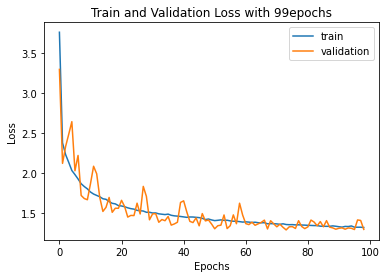

In [171]:
patience=25

# plot training and validation history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+'epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))

In [172]:
predict1=np.zeros((l2r,1))
for i in range(l2r):
    predict1[i]=predictions[i*test_size+test_size-3]
    
predict2=np.zeros((l2r,1))
for i in range(l2r):
    predict2[i]=predictions[i*test_size+test_size-2]
    
predict3=np.zeros((l2r,1))
for i in range(l2r):
    predict3[i]=predictions[i*test_size+test_size-1]

NameError: name 'data' is not defined

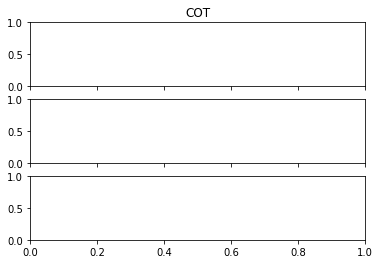

In [173]:
# plotting ------------------------------------------------------
fgnm = "predict"+"_"+str(ltype)+"_"+str(bsize)+"_"+str(len(history.history['val_loss'])-patience)+'epochs_3_layers'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True)

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"COT")
ax.plot(x[halo:os*l2r+halo],data[num-3,halo:os*l2r+halo,3].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo],predict1.reshape(4066),alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 1") 

#plot the second last profile
ax = axs[1]
ax.plot(x[halo:os*l2r+halo],data[num-2,halo:os*l2r+halo,3].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo],predict2.reshape(4066),alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 2")  

# plot the last profile
ax = axs[2]
ax.plot(x[halo:os*l2r+halo],data[num-1,halo:os*l2r+halo,3].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo],predict3.reshape(4066),alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 3")  
ax.set_xlabel('X [km]')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')




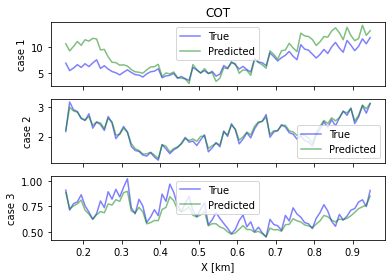

In [22]:
# plotting ------------------------------------------------------
fgnm = "predict"+"_"+str(ltype)+"_"+str(bsize)+"_"+str(len(history.history['val_loss'])-patience)+"epochs_first_80_pixels"+'_3_layers'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True)

# plots the first 80 pixels in last three test images

#plot the third last profile
ax = axs[0]
ax.set_title(r"COT")
ax.plot(x[halo:os*l2r+halo][:80],data[num-3,halo:os*l2r+halo,3][:80].T,alpha=0.5,color="blue") 
ax.plot(x[halo:os*l2r+halo][:80],predict1.reshape(4066)[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 1") 

#plot the second last profile
ax = axs[1]
ax.plot(x[halo:os*l2r+halo][:80],data[num-2,halo:os*l2r+halo,3][:80].T,alpha=0.5,color="blue") 
ax.plot(x[halo:os*l2r+halo][:80],predict2.reshape(4066)[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 2")  

# plot the last profile
ax = axs[2]
ax.plot(x[halo:os*l2r+halo][:80],data[num-1,halo:os*l2r+halo,3][:80].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo][:80],predict3.reshape(4066)[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 3")  
ax.set_xlabel('X [km]')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')